**About Dataset**

* Context

  The whole world is suffering from COVID-19 disease and its proper and timely diagnosis is the need of the hour. So for building an efficient AI-based diagnostic system we have collected Chest ray images from different sources so that we can train our CNN model for automating the whole diagnosis method. Therefore we have collected Chest ray images from different sources and research papers and combined them to create one comprehensive dataset that can be used by research community.

  This dataset is also used in COVID Lite paper which has shown significant results by building novel CNN based solution.

* Content

  This dataset consists of a posteroanterior (PA) view of chest X-ray images comprising Normal, Viral, and CVOID-19 affected patients. There are total 1709 CXR images.

In [ ]:
!pip install --upgrade tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

In [ ]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shutil
import os
import shutil
from tqdm import tqdm
import glob as gb

import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, optimizers, Model
from keras.models import Sequential, Model
from keras.layers import *

# **Data Exploration**

In [ ]:
data_dir = '/content/drive/MyDrive/Covid-19/Data'

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Covid-19/Data1.csv')
data

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal
...,...,...
1161,118777221.jpeg,virus
1162,375945707.jpeg,normal
1163,531745860.jpeg,virus
1164,121544623.jpeg,covid


In [ ]:
data['Label'].value_counts()

Label
normal    458
virus     423
covid     285
Name: count, dtype: int64

In [ ]:
px.histogram(data, y="Label", color="Label", title="Classes Distribution")

* **Covid Class Being Less Present than others.**

In [ ]:
Classes = ['covid', 'normal', 'virus']

In [ ]:
def Plot_Classes(BASE_URL, Classes, Rows=2, Columns=5):
    """
    Plot a Random Image of Each Class in Train/Test Folder.
    """

    plt.figure(figsize=(25, 8))
    image_count = 1

    for class_name in Classes:
        class_path = os.path.join(BASE_URL, class_name)
        if os.path.exists(class_path):
            files = os.listdir(class_path)
            if files:
                random_file = np.random.choice(files)
                image_path = os.path.join(class_path, random_file)
                image = plt.imread(image_path)
                plt.subplot(Rows, Columns, image_count)
                plt.imshow(image)
                plt.title(class_name)
                image_count += 1

    plt.tight_layout()
    plt.show()

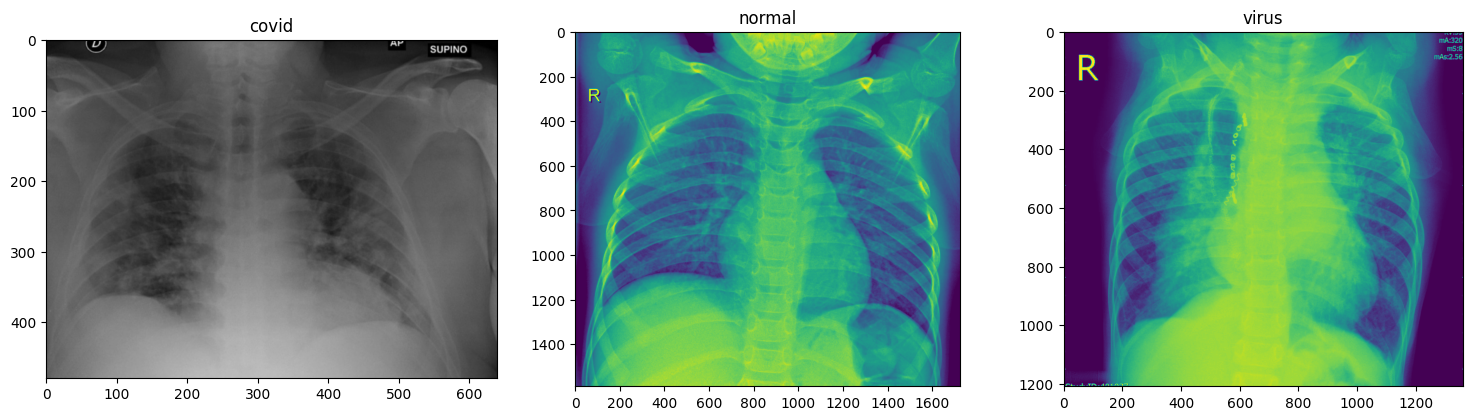

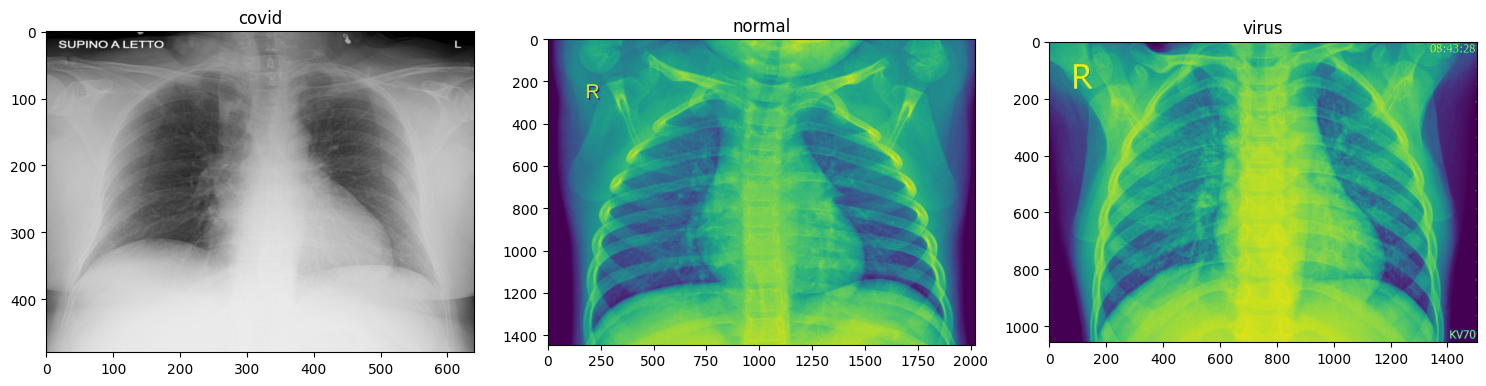

In [ ]:
Plot_Classes(data_dir, Classes)
Plot_Classes(data_dir, Classes)

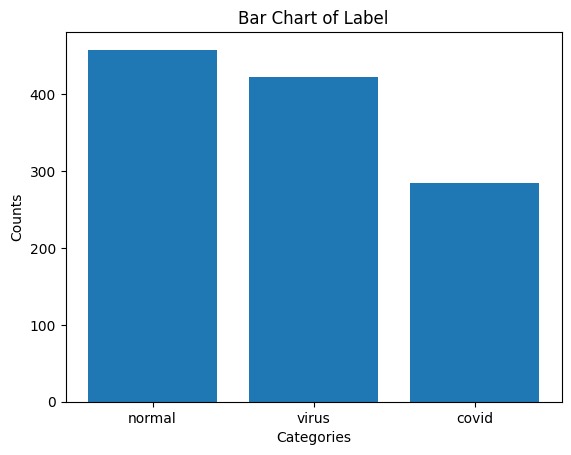

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Covid-19/Data1.csv')

# Select a categorical feature from your dataset
categorical_feature = 'Label'

# Plot bar chart
plt.bar(df[categorical_feature].value_counts().index, df[categorical_feature].value_counts())
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Bar Chart of ' + categorical_feature)
plt.show()


In [ ]:
size = []
for folder in os.listdir(data_dir):
    # Construct the directory path for the current folder
    folder_path = os.path.join(data_dir, folder)

    # Use glob to find image files in the current folder
    files_je = gb.glob(pathname=os.path.join(folder_path, '*.jpeg'))
    files_jp = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
    files_pn = gb.glob(pathname=os.path.join(folder_path, '*.png'))

    # Concatenate all found files
    files = files_je + files_jp + files_pn

    # Iterate through each file and collect its size
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)

# Count the occurrences of each unique image size
pd.Series(size).value_counts()


(480, 640, 3)      132
(480, 640)          14
(480, 640, 4)       10
(842, 1024, 3)       6
(1024, 1024, 3)      3
                  ... 
(1105, 1402)         1
(1106, 1492)         1
(900, 1268)          1
(1611, 1964)         1
(574, 863, 3)        1
Name: count, Length: 985, dtype: int64

(480, 640, 3)


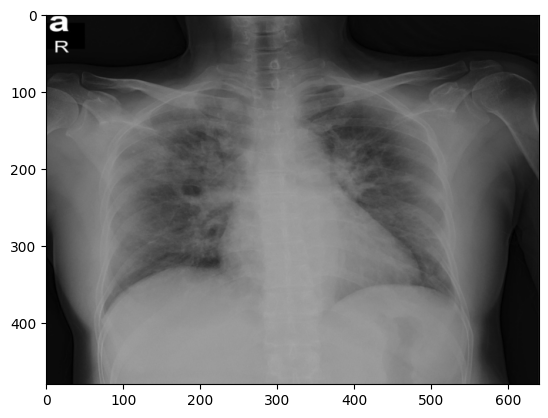

In [ ]:
covidImg = plt.imread('/content/drive/MyDrive/Covid-19/Data/covid/100126173.png')
print(covidImg.shape)
plt.imshow(covidImg)

In [ ]:
covidImg[0]

array([[0.05098039, 0.05098039, 0.05098039],
       [0.05098039, 0.05098039, 0.05098039],
       [0.04705882, 0.04705882, 0.04705882],
       ...,
       [0.04313726, 0.04313726, 0.04313726],
       [0.03529412, 0.03529412, 0.03529412],
       [0.10196079, 0.10196079, 0.10196079]], dtype=float32)

- **Notice that the Covid Class Images are Represented as RGB Array of Images and it's Float Type (normalized).**

(1228, 1480)


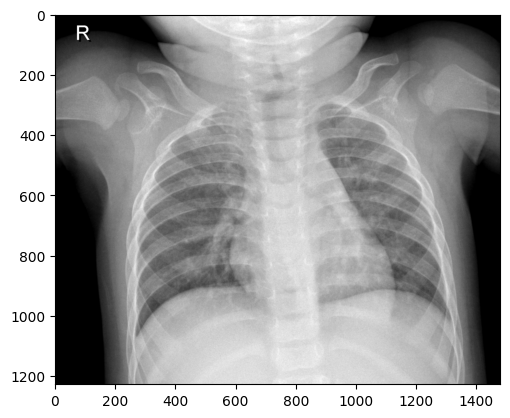

In [ ]:
normalImg = plt.imread('/content/drive/MyDrive/Covid-19/Data/normal/100399932.jpeg')
print(normalImg.shape)
plt.imshow(normalImg, cmap='gray')

In [ ]:
normalImg[normalImg!=0]

array([ 1,  6, 13, ..., 13,  5,  1], dtype=uint8)

(720, 1240)


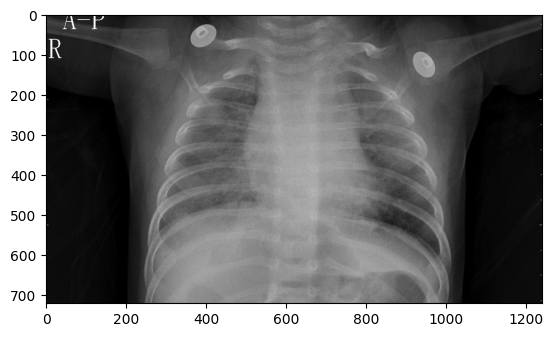

In [ ]:
virusImg = plt.imread('/content/drive/MyDrive/Covid-19/Data/virus/100770198.jpeg')
print(virusImg.shape)
plt.imshow(virusImg, cmap='gray')

In [ ]:
virusImg[virusImg!=0]

array([33, 32, 31, ...,  9, 13, 15], dtype=uint8)

- **Unlike the other two Classes being real gray scaled images with int Types(not normalized).**

# **Data Preprocessing**

In [ ]:
for index, row in data.iterrows():
    path_to_img = data_dir +'/'+ row['Label'] + '/' + row['Image']
    data.at[index, 'Image'] = path_to_img


In [ ]:
data.head()

,Image,Label
0,/content/drive/MyDrive/Covid-19/Data/normal/59...,normal
1,/content/drive/MyDrive/Covid-19/Data/virus/352...,virus
2,/content/drive/MyDrive/Covid-19/Data/normal/46...,normal
3,/content/drive/MyDrive/Covid-19/Data/normal/35...,normal
4,/content/drive/MyDrive/Covid-19/Data/normal/61...,normal


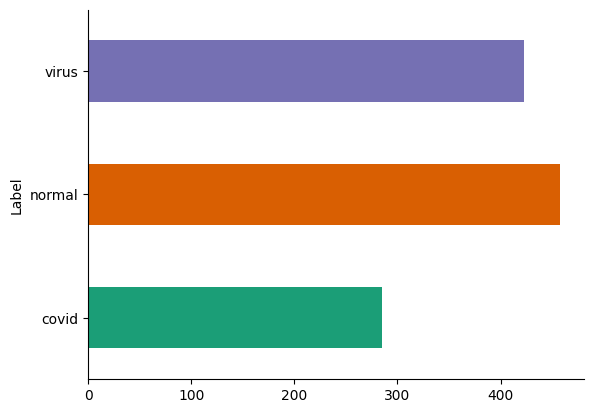

In [ ]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# prompt: Using dataframe data: bar plot

import altair as alt
chart = alt.Chart(data).mark_bar().encode(x='Label', y='count()')
chart


alt.Chart(...)

- **Now Let's Split the Data to Train-Test Split that have the Same Class Distribution as Original Data.**

In [ ]:
x = data.drop(columns="Label")
y = data["Label"]
x.head()


,Image
0,/content/drive/MyDrive/Covid-19/Data/normal/59...
1,/content/drive/MyDrive/Covid-19/Data/virus/352...
2,/content/drive/MyDrive/Covid-19/Data/normal/46...
3,/content/drive/MyDrive/Covid-19/Data/normal/35...
4,/content/drive/MyDrive/Covid-19/Data/normal/61...


In [ ]:
# Validation Split
x_train, x_test, y_train, y_test = train_test_split( x , y , test_size=0.15, random_state=0 )


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(991, 1)
(991,)
(175, 1)
(175,)


In [ ]:
train_df = pd.concat([x_train,y_train], axis = 1)

px.histogram(train_df, y="Label", color="Label", title="Train Classes Distribution").update_yaxes(categoryorder='total ascending')

In [ ]:
test_df = pd.concat([x_test,y_test], axis = 1)

px.histogram(test_df, y="Label", color="Label", title="Test Classes Distribution").update_yaxes(categoryorder='total ascending')

- **Notice how all the splits have the same classes distribution to the original data.**

## **Image Data Generators**




In [ ]:
train_df.head()

,Image,Label
1032,/content/drive/MyDrive/Covid-19/Data/virus/204...,virus
760,/content/drive/MyDrive/Covid-19/Data/virus/439...,virus
1114,/content/drive/MyDrive/Covid-19/Data/virus/453...,virus
60,/content/drive/MyDrive/Covid-19/Data/covid/129...,covid
224,/content/drive/MyDrive/Covid-19/Data/normal/47...,normal


In [ ]:
img_shape = 150

color_type = 3

batch_size = 32

In [ ]:
train_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    seed=0
)

test_data = test_preprocessor.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    seed=0
)


Found 991 validated image filenames belonging to 3 classes.
Found 175 validated image filenames belonging to 3 classes.


In [ ]:
print("Number of Train batches:", len(train_data))
print("Number of Val batches:", len(test_data))

Number of Train batches: 31
Number of Val batches: 6


## **Checking Generators**

In [ ]:
Classes_Map = train_data.class_indices

Num_Classes = len(Classes_Map)

print("Number of Classes:", Num_Classes)
Classes_Map

Number of Classes: 3


{'covid': 0, 'normal': 1, 'virus': 2}

In [ ]:
train_data[0][0][0]

array([[[0.11764707, 0.11764707, 0.11764707],
        [0.10980393, 0.10980393, 0.10980393],
        [0.10980393, 0.10980393, 0.10980393],
        ...,
        [0.07450981, 0.07450981, 0.07450981],
        [0.06666667, 0.06666667, 0.06666667],
        [0.09803922, 0.09803922, 0.09803922]],

       [[0.10980393, 0.10980393, 0.10980393],
        [0.10588236, 0.10588236, 0.10588236],
        [0.10980393, 0.10980393, 0.10980393],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.06666667, 0.06666667, 0.06666667],
        [0.08235294, 0.08235294, 0.08235294]],

       [[0.10588236, 0.10588236, 0.10588236],
        [0.10980393, 0.10980393, 0.10980393],
        [0.1137255 , 0.1137255 , 0.1137255 ],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.07058824, 0.07058824, 0.07058824],
        [0.07450981, 0.07450981, 0.07450981]],

       ...,

       [[0.06666667, 0.06666667, 0.06666667],
        [0.07450981, 0.07450981, 0.07450981],
        [0.06666667, 0

[1. 0. 0.]


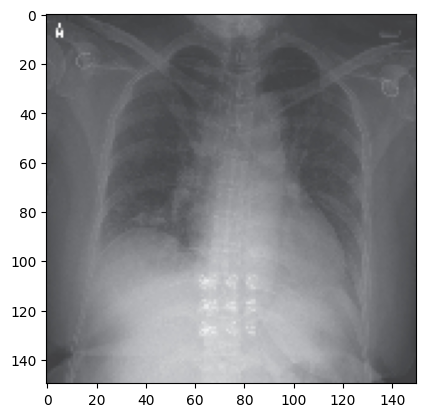

In [ ]:
plt.imshow(train_data[0][0][-1])
print(train_data[0][1][-1])

In [ ]:
test_data[1][0][-1]

array([[[0.3921569 , 0.3921569 , 0.3921569 ],
        [0.40784317, 0.40784317, 0.40784317],
        [0.4039216 , 0.4039216 , 0.4039216 ],
        ...,
        [0.4666667 , 0.4666667 , 0.4666667 ],
        [0.6156863 , 0.6156863 , 0.6156863 ],
        [0.9215687 , 0.9215687 , 0.9215687 ]],

       [[0.40000004, 0.40000004, 0.40000004],
        [0.41960788, 0.41960788, 0.41960788],
        [0.40784317, 0.40784317, 0.40784317],
        ...,
        [0.4666667 , 0.4666667 , 0.4666667 ],
        [0.627451  , 0.627451  , 0.627451  ],
        [0.8941177 , 0.8941177 , 0.8941177 ]],

       [[0.3803922 , 0.3803922 , 0.3803922 ],
        [0.40784317, 0.40784317, 0.40784317],
        [0.40000004, 0.40000004, 0.40000004],
        ...,
        [0.45098042, 0.45098042, 0.45098042],
        [0.6039216 , 0.6039216 , 0.6039216 ],
        [0.86666673, 0.86666673, 0.86666673]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

[0. 1. 0.]


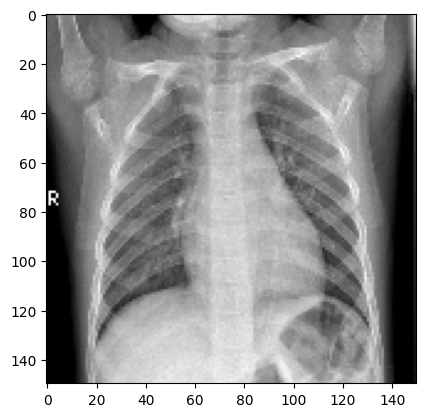

In [ ]:
plt.imshow(test_data[1][0][-1])
print(test_data[1][1][-1])

- **We Notice that all the images now are represnted as gray scale float arrays (normalized images).**

# **CNN Model**

### **CNN Model Architecture**

In [ ]:
def Create_CNN_Model():

    model = Sequential()

    model.add(Conv2D(32,(3,3), activation='relu', input_shape=(img_shape, img_shape, color_type)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    #Output
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense( Num_Classes , activation='softmax',input_shape=(img_shape, img_shape, color_type)))

    return model

In [ ]:
cnn_model = Create_CNN_Model()

cnn_model.summary()

cnn_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### **Fitting CNN Model**

In [ ]:
cnn_history = cnn_model.fit(train_data , validation_data= test_data , epochs=30 , batch_size=batch_size)

Epoch 1/30
31/31 [==============================] - 74s 2s/step - loss: 0.9583 - accuracy: 0.4955 - val_loss: 0.5297 - val_accuracy: 0.7886
Epoch 2/30
31/31 [==============================] - 69s 2s/step - loss: 0.4656 - accuracy: 0.8184 - val_loss: 0.4096 - val_accuracy: 0.8629
Epoch 3/30
31/31 [==============================] - 74s 2s/step - loss: 0.3429 - accuracy: 0.8708 - val_loss: 0.3188 - val_accuracy: 0.9086
Epoch 4/30
31/31 [==============================] - 73s 2s/step - loss: 0.2907 - accuracy: 0.8930 - val_loss: 0.2973 - val_accuracy: 0.9257
Epoch 5/30
31/31 [==============================] - 73s 2s/step - loss: 0.2339 - accuracy: 0.9183 - val_loss: 0.2668 - val_accuracy: 0.9371
Epoch 6/30
31/31 [==============================] - 72s 2s/step - loss: 0.1505 - accuracy: 0.9506 - val_loss: 0.2722 - val_accuracy: 0.9257
Epoch 7/30
31/31 [==============================] - 74s 2s/step - loss: 0.1519 - accuracy: 0.9455 - val_loss: 0.2985 - val_accuracy: 0.9086
Epoch 8/30
31/31 [==

## **CNN Model Evaluation**

In [ ]:
cnn_scores = cnn_model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(cnn_scores[0]))
print("Test Accuracy: {:.2f}%".format(cnn_scores[1] * 100))

6/6 [==============================] - 5s 740ms/step - loss: 0.3429 - accuracy: 0.9543
    Test Loss: 0.34288
Test Accuracy: 95.43%


In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')

  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

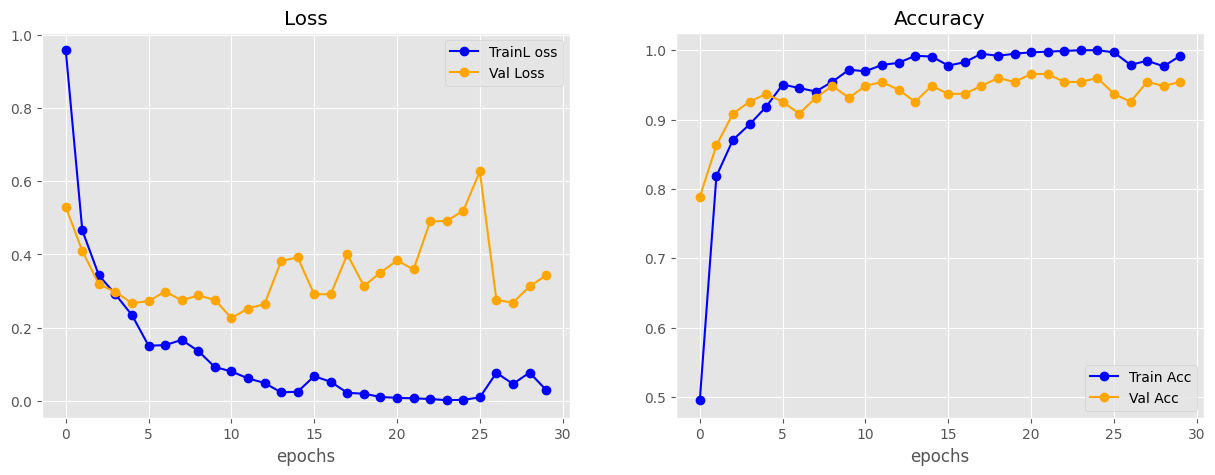

In [ ]:
plot_curves(cnn_history)

In [ ]:
cnn_predictions_probs = cnn_model.predict(test_data)

# Choosing highest probalbilty class in every prediction
cnn_predictions = np.argmax(cnn_predictions_probs, axis=1)

6/6 [==============================] - 6s 818ms/step


[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

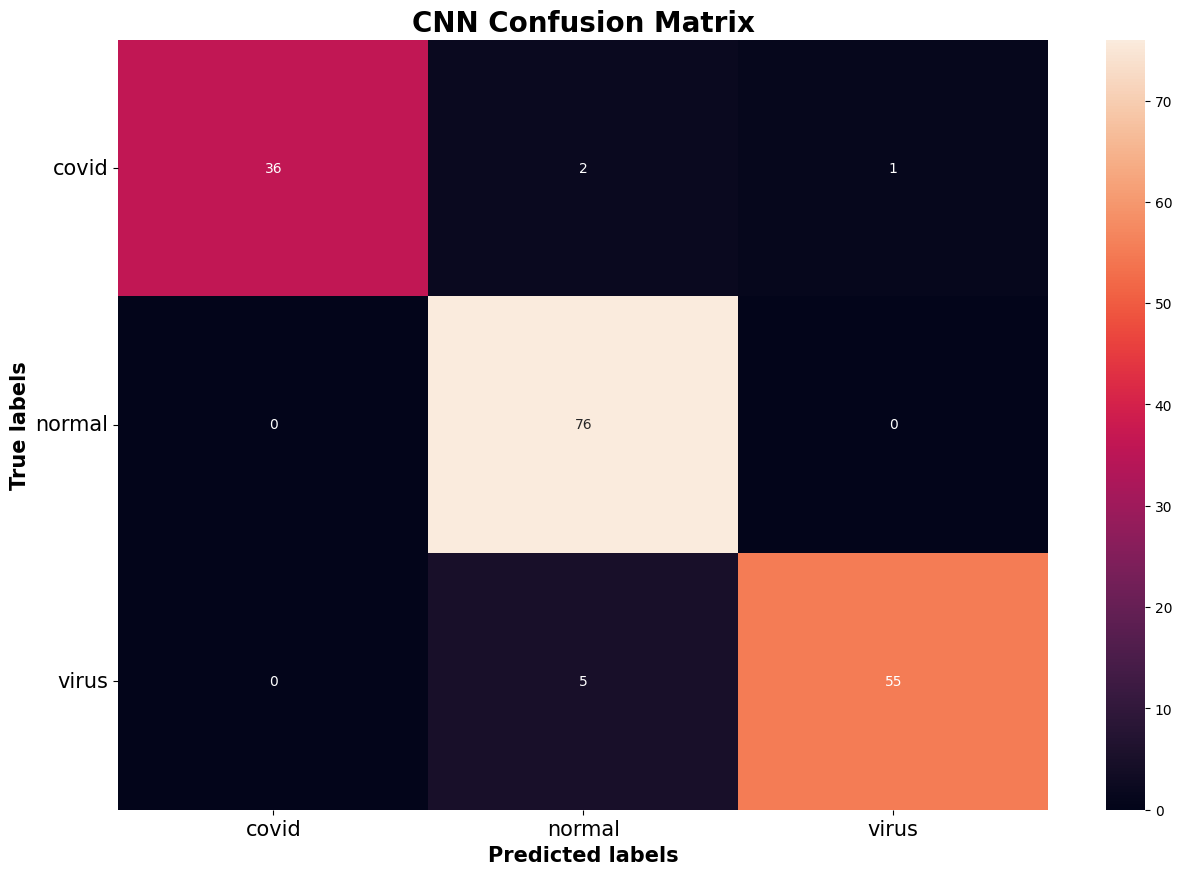

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, cnn_predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Classes , fontsize=15)
ax.set_yticklabels(Classes, rotation=0, fontsize=15)

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(test_data.labels, cnn_predictions, target_names= Classes)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       1.00      0.92      0.96        39
      normal       0.92      1.00      0.96        76
       virus       0.98      0.92      0.95        60

    accuracy                           0.95       175
   macro avg       0.97      0.95      0.95       175
weighted avg       0.96      0.95      0.95       175



In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, cnn_predictions) * 100))

Test Accuracy: 95.43%


- **The Testing Accuracy after 30 Epochs was about 94.44%, Perhaps it would increase with more epochs but it will not be a huge increase.**

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have already trained and compiled your model, named `model`
# Train and compile your model here...

# Save the model to a file
cnn_model.save("/content/drive/MyDrive/savedmodels.keras")


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/savedmodels.h5")

# Load and preprocess the external image
image_path = "/content/drive/MyDrive/virusextra/6843754.jpeg"
img = cv2.imread(image_path)
img = cv2.resize(img, (150, 150))  # Resize image to match model input size
img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(img)

# Interpret the predictions
# Assuming your model is a classification model
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)
# Visualize the activation maps


1/1 [==============================] - 0s 126ms/step
Predicted class: [2]


- **Transfer Learning will be useful, with more complex model architectures it will be able to achieve fit the data better.**

# **VGG-16 Model**

In [ ]:
from keras.applications.vgg16 import VGG16


VGG_16 = VGG16(input_shape=(img_shape, img_shape, color_type),
              include_top= False,
              weights='imagenet',
              )

VGG_16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### **Freezing Layers**

In [ ]:
# Freezing all layers except last 10

VGG_16.trainable = True

Trainable_Layers = 10

for layer in VGG_16.layers[ : -Trainable_Layers ]:
    layer.trainable = False

VGG_16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### **VGG-16 Model Architecture**

In [ ]:
def Create_VGG16_Model():

  model = Sequential([
                      VGG_16,

                      GlobalAveragePooling2D(),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.5),

                      Dense( Num_Classes, activation='softmax')
                    ])

  return model

In [ ]:
VGG16_Model = Create_VGG16_Model()

VGG16_Model.summary()

optimizer = keras.optimizers.Adam(0.0001)

VGG16_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### **Fitting VGG-16 Model**

In [ ]:
VGG16_history = VGG16_Model.fit(train_data ,validation_data = test_data , epochs=30 , batch_size=batch_size)

Epoch 1/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 285s 9s/step - accuracy: 0.3367 - loss: 1.1401 - val_accuracy: 0.5611 - val_loss: 0.9713

Epoch 2/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 281s 9s/step - accuracy: 0.4260 - loss: 0.9762 - val_accuracy: 0.7000 - val_loss: 0.7188

Epoch 3/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.6109 - loss: 0.8126 - val_accuracy: 0.7056 - val_loss: 0.6659

Epoch 4/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 325s 9s/step - accuracy: 0.6346 - loss: 0.8001 - val_accuracy: 0.7389 - val_loss: 0.5789

Epoch 5/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 320s 9s/step - accuracy: 0.6753 - loss: 0.6419 - val_accuracy: 0.7611 - val_loss: 0.3827

Epoch 6/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 284s 9s/step - accuracy: 0.7139 - loss: 0.4759 - val_accuracy: 0.7833 - val_loss: 0.3763

Epoch 7/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 321s 9s/step - accuracy: 0.8189 - loss: 0.4327 - val_accuracy: 0.9333 - val_loss: 0.3180

Epoch 8/30

32/32 ━━━━━━━━━━━━━━━━━━━━ 280s 9s/step - accuracy: 0.9410 - loss: 0.3761 - val_accur

In [ ]:
VGG16_Scores = VGG16_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(VGG16_Scores[0]))
print("Test Accuracy: {:.2f}%".format(VGG16_Scores[1] * 100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9795 - loss: 0.3804

    Test Loss: 0.23116

Test Accuracy: 98.33%


### **VGG-16 Model Evaluation**

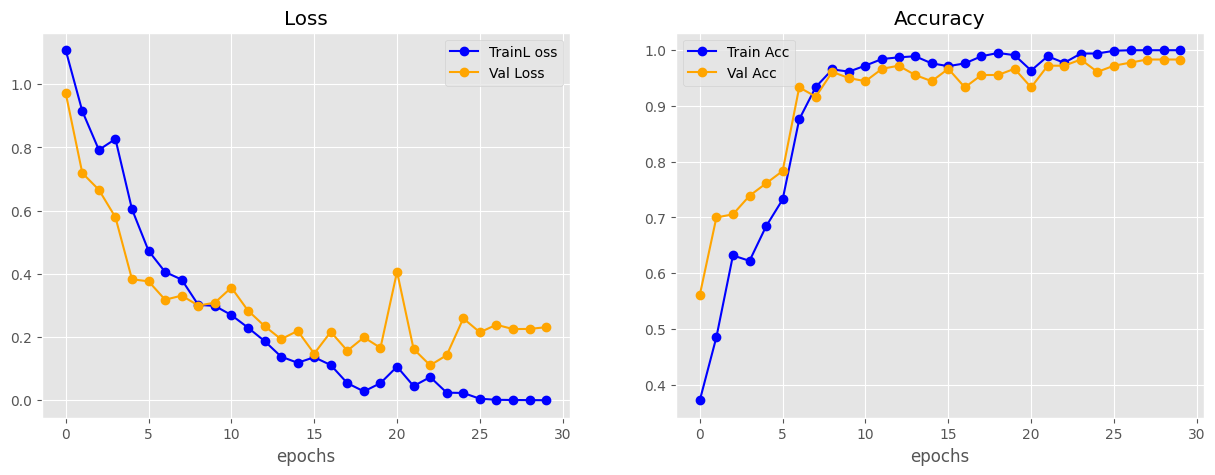

In [ ]:
plot_curves(VGG16_history)

**Predicting the Test Set**

In [ ]:
VGG16_Predictions_Probs = VGG16_Model.predict(test_data)

VGG16_Predictions = np.argmax(VGG16_Predictions_Probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

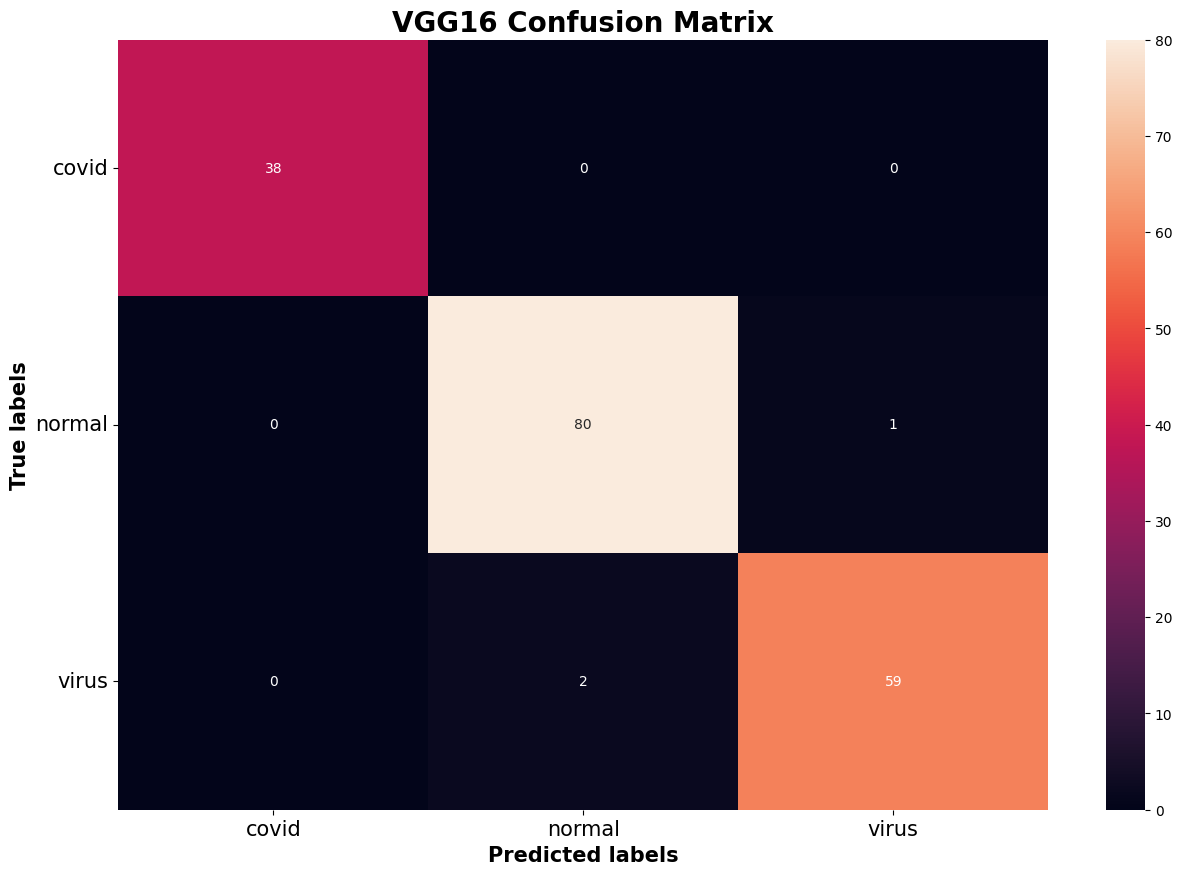

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, VGG16_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Classes , fontsize=15)
ax.set_yticklabels(Classes, rotation=0, fontsize=15)

**Classification Report**

In [ ]:
ClassificationReport = classification_report(test_data.labels, VGG16_Predictions, target_names= Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 

               precision    recall  f1-score   support



       covid       1.00      1.00      1.00        38

      normal       0.98      0.99      0.98        81

       virus       0.98      0.97      0.98        61



    accuracy                           0.98       180

   macro avg       0.99      0.98      0.99       180

weighted avg       0.98      0.98      0.98       180




In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, VGG16_Predictions) * 100))

Test Accuracy: 98.33%


{'covid': 0.047, 'normal': 99.604, 'virus': 0.348}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}

{'covid': 100.0, 'normal': 0.0, 'virus': 0.0}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}

{'covid': 0.0, 'normal': 0.0, 'virus': 100.0}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}

{'covid': 100.0, 'normal': 0.0, 'virus': 0.0}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}

{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}


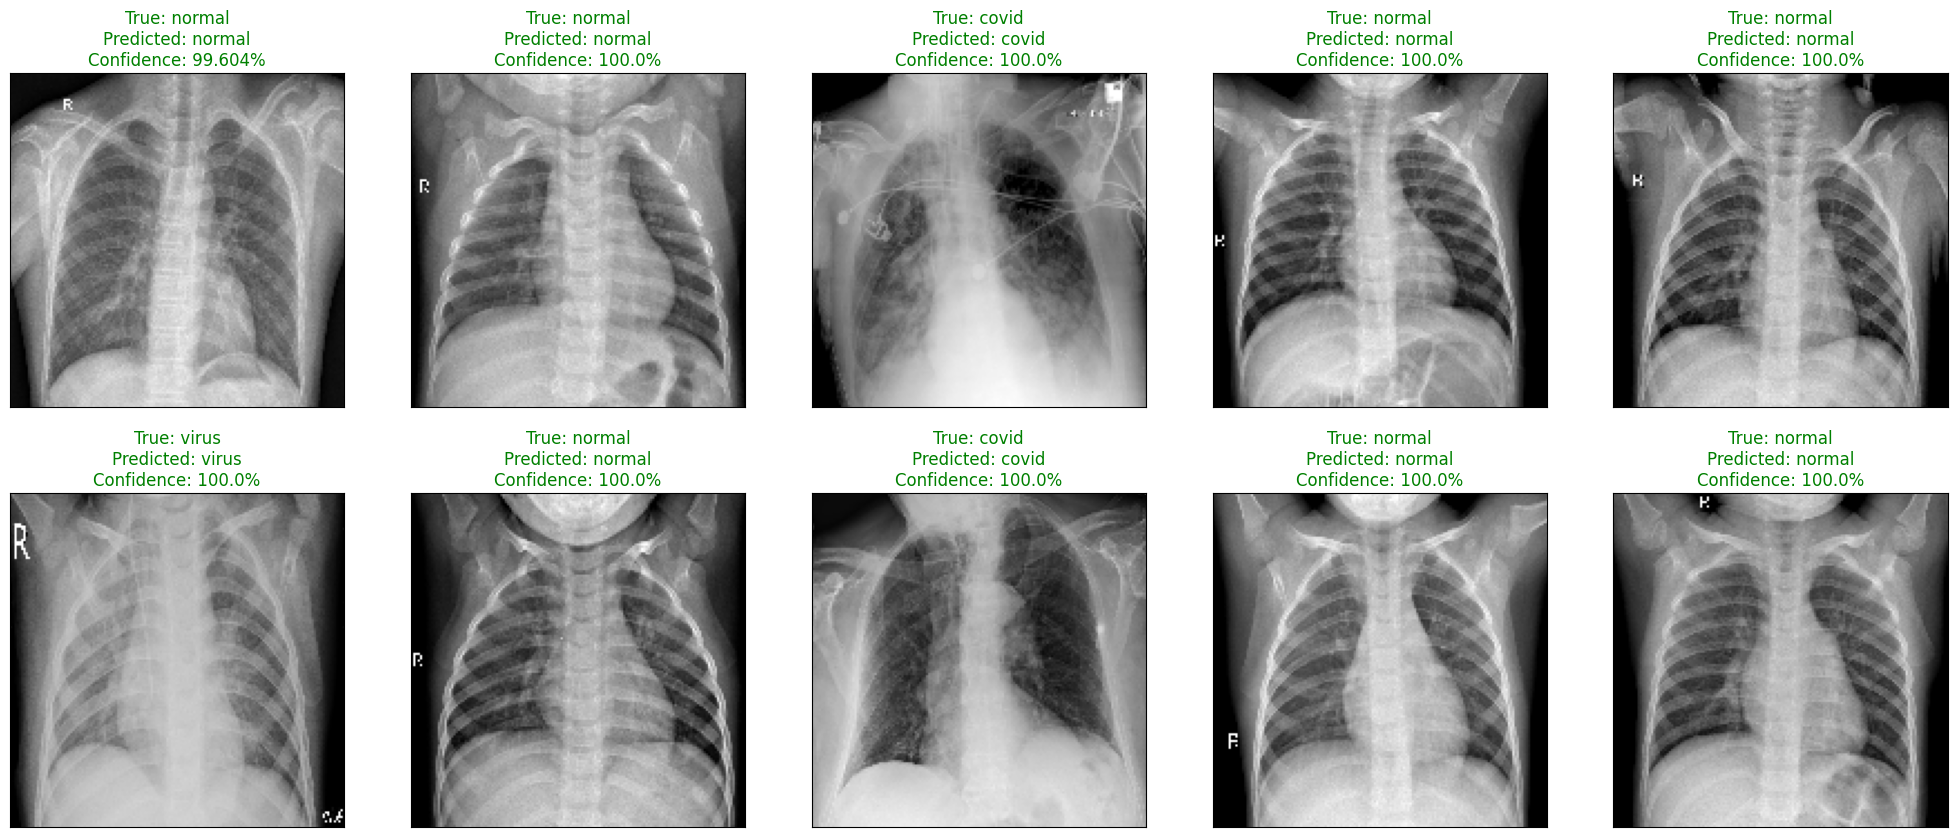

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures predictions from the dataset with their labels

Random_batch = np.random.randint(0, len(test_data))

Random_Img_Index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]])

    Model_Predictions = VGG16_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)

    Model_Highest_Prediction = np.argmax(Model_Predictions)

    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (Classes, Model_Predictions.tolist()[0] ) }

    ax.imshow(Random_Img)

    Pred_Class = Classes[Model_Highest_Prediction]

    if Classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {Classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()

* **VGG-16 Gave the Best Performance with 98.33% Accuracy and 98% F1 Score**